<a href="https://colab.research.google.com/github/Vishnu-bhat/Traffic-Management-System-using-YOLO/blob/main/SIGNAL_TIME_Prediction_Using_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# Load dataset
df = pd.read_csv("/content/traffic_signal_dataset.csv")

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X1             15000 non-null  int64  
 1   X2             15000 non-null  int64  
 2   X3             15000 non-null  int64  
 3   X4             15000 non-null  int64  
 4   X5             15000 non-null  int64  
 5   X6             15000 non-null  int64  
 6   X7             15000 non-null  int64  
 7   X8             15000 non-null  int64  
 8   green_1        15000 non-null  int64  
 9   green_2        15000 non-null  int64  
 10  Average_Delay  15000 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 1.3 MB


(None,
    X1  X2  X3  X4  X5  X6  X7  X8  green_1  green_2  Average_Delay
 0  38  28  14  42   7  20  38  18       30       32           8.51
 1  38  28  14  42   7  20  38  18       30       34           7.37
 2  38  28  14  42   7  20  38  18       30       36           7.06
 3  38  28  14  42   7  20  38  18       30       38           7.42
 4  38  28  14  42   7  20  38  18       30       40           7.49)

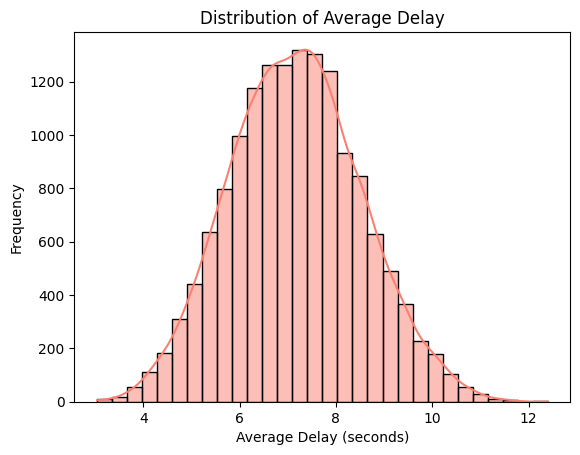

In [ ]:
# 1. Distribution of Average Delay
sns.histplot(df['Average_Delay'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Average Delay")
plt.xlabel("Average Delay (seconds)")
plt.ylabel("Frequency")
plt.show()

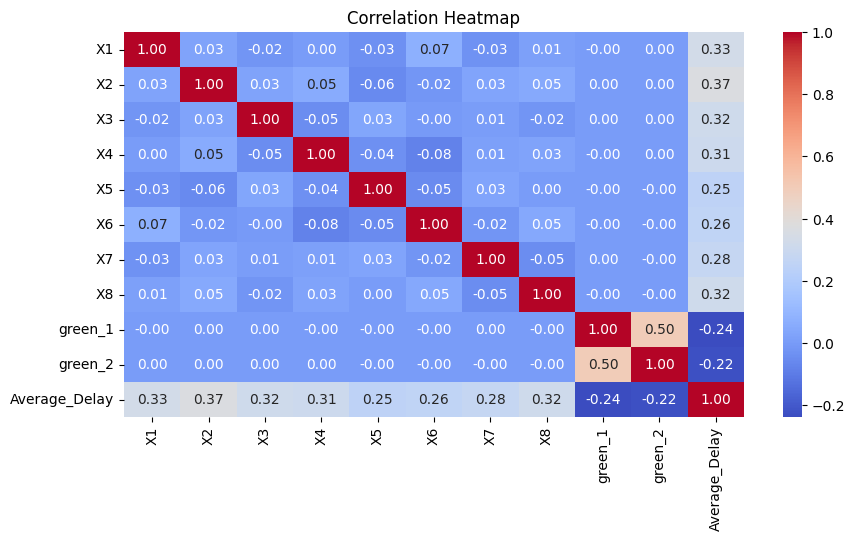

In [ ]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 5))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

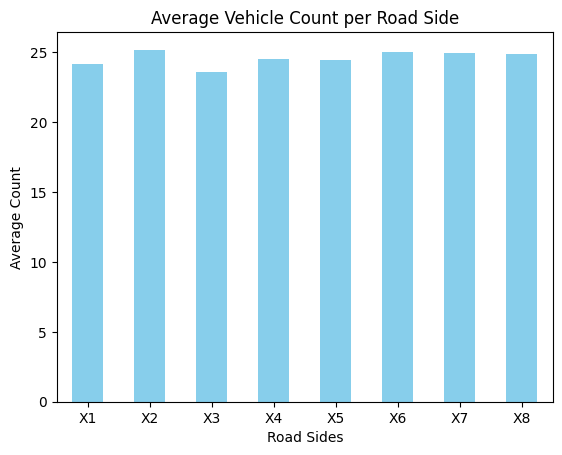

In [ ]:
# 3. Vehicle Count per Road Side
vehicle_cols = [f'X{i}' for i in range(1, 9)]

df[vehicle_cols].mean().plot(kind='bar', color='skyblue')
plt.title("Average Vehicle Count per Road Side")
plt.ylabel("Average Count")
plt.xlabel("Road Sides")
plt.xticks(rotation=0)
plt.show()


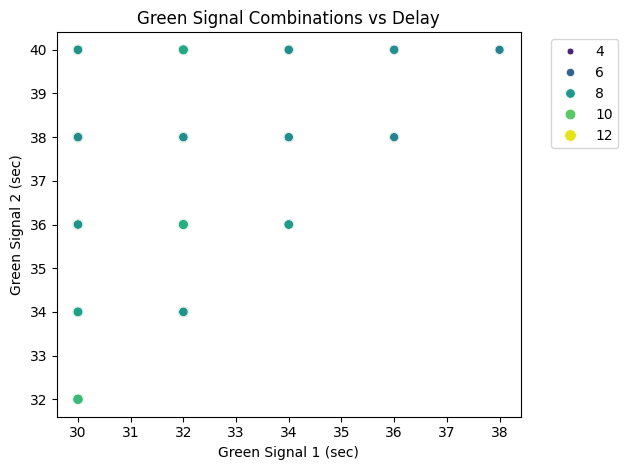

In [ ]:
# 4. Green Signal Timing Combinations Scatter

sns.scatterplot(x='green_1', y='green_2', hue='Average_Delay', data=df, palette='viridis', size='Average_Delay')
plt.title("Green Signal Combinations vs Delay")
plt.xlabel("Green Signal 1 (sec)")
plt.ylabel("Green Signal 2 (sec)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

X = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'green_1', 'green_2']]
y = df['Average_Delay']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter grid for randomized search
param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Randomized search setup
search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
search.fit(X_train, y_train)

# Best model and evaluation
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Best Parameters:", search.best_params_)
print("MSE on Test Set:", mse)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
MSE on Test Set: 0.36794507718485087


In [ ]:
import numpy as np
import itertools

# Define possible green timings (30 to 40 with step of 2)
green_timings = list(range(30, 42, 2))
green_combinations = list(itertools.combinations(green_timings, 2))  # 36 combinations

# input
new_input = [10, 43, 25, 36, 22, 28, 20, 47]  # X1 to X8

# Create input set for all green timing combinations
input_variants = [new_input + [g1, g2] for g1, g2 in green_combinations]
input_df = pd.DataFrame(input_variants, columns=['X1','X2','X3','X4','X5','X6','X7','X8','green_1','green_2'])

# Predict delays for each combination
# Changed 'model' to 'best_model'
predicted_delays = best_model.predict(input_df)

# Get the combination with minimum predicted delay
min_index = np.argmin(predicted_delays)
optimal_combination = green_combinations[min_index]
optimal_delay = predicted_delays[min_index]

print("Optimal green timing (green_1, green_2):", optimal_combination)
print("Predicted minimum delay:", optimal_delay)


Optimal green timing (green_1, green_2): (38, 40)
Predicted minimum delay: 7.283726


In [ ]:
import joblib

# Save the best model to a file
joblib.dump(best_model, 'xgboost_traffic_model.pkl')

print("Model saved as 'xgboost_traffic_model.pkl'")


Model saved as 'xgboost_traffic_model.pkl'


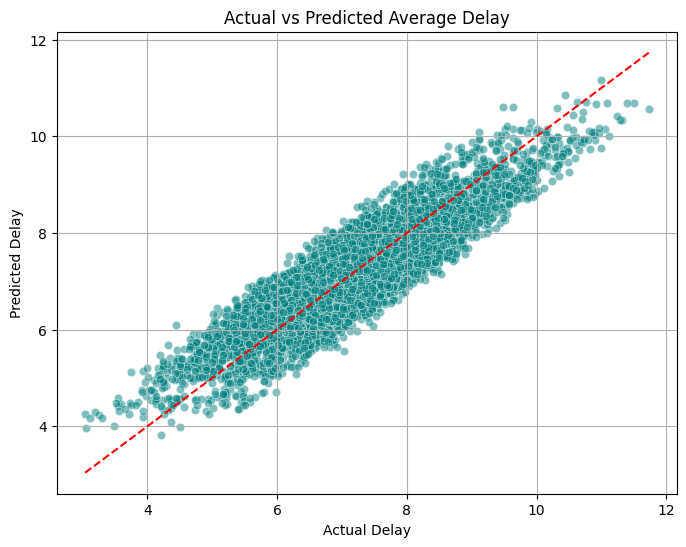

In [ ]:

from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = best_model.predict(X_test)

# 1. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y=x line
plt.title("Actual vs Predicted Average Delay")
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.grid(True)
plt.show()

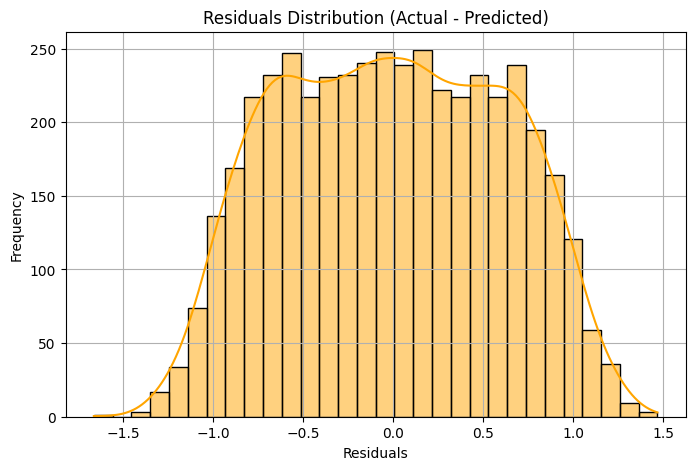

In [ ]:
# 2. Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# 3. R2 and MSE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.3679
R² Score: 0.8036
